In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import convolve, gaussian_filter

In [2]:
file_path = "data\\assignmentSegmentBrain.mat"
with h5py.File(file_path, 'r') as mat_file:
    for key in mat_file.keys():
        print(f"Dataset: {key}, Shape: {mat_file[key].shape}")


Dataset: imageData, Shape: (256, 256)
Dataset: imageMask, Shape: (256, 256)


In [3]:
file_path = "data\\assignmentSegmentBrain.mat"
with h5py.File(file_path, 'r') as mat_file:
    data = np.array(mat_file['imageData'])
    mask = np.array(mat_file['imageMask'])

In [4]:
print(data)

[[0.01509826 0.03601538 0.03767066 ... 0.0304323  0.05833644 0.04709785]
 [0.01886725 0.01501652 0.02699185 ... 0.03882585 0.02455803 0.02357   ]
 [0.02461856 0.02221822 0.05561578 ... 0.00485265 0.02609188 0.03824265]
 ...
 [0.02028591 0.05049168 0.01715932 ... 0.03000725 0.03058744 0.08944161]
 [0.04449398 0.05145801 0.04347878 ... 0.03037082 0.01560842 0.06840941]
 [0.05579706 0.06766721 0.02346222 ... 0.07711918 0.03618063 0.01464482]]


Text(0.5, 1.0, 'imageMask')

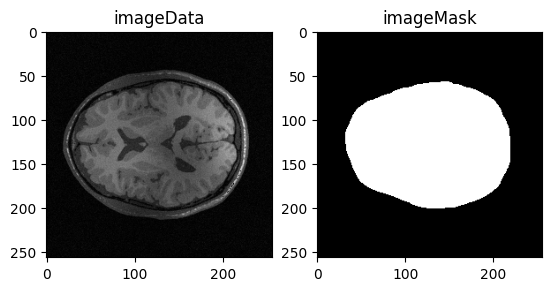

In [5]:
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='gray')
plt.title('imageData')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('imageMask')

(256, 256)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


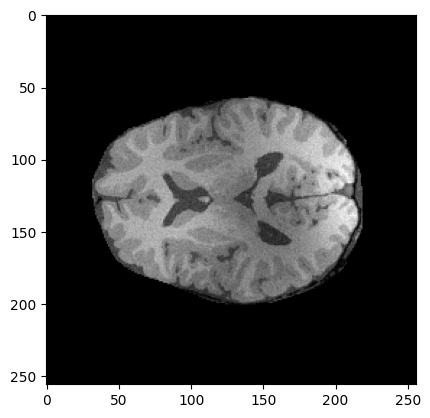

In [6]:
# Multiplying each pixel with the mask to remove the part outside the mask
brainData = data * mask
print(brainData.shape)
plt.imshow(brainData, cmap='gray')
print(brainData)

In [7]:
max_iter = 20
tol = 1e-4

data = data
Y = brainData.astype(np.float64)         # Corrupted brain MR image
mask = mask.astype(np.bool_)      # Binary brain mask

# Normalize image intensity to [0, 1]
Y = Y / np.max(Y)

# Number of classes (white, gray, CSF)
K = 3  

# Set fuzzifier parameter q (must be > 1.5)
q = 2.0  
print("Chosen fuzzifier parameter q =", q)

Chosen fuzzifier parameter q = 2.0


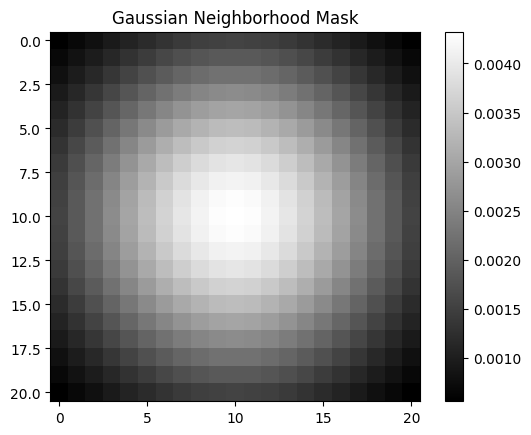

In [8]:
# Create Gaussian neighborhood mask (5x5, sigma=1)
size = 21
sigma = 7.0
ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
xx, yy = np.meshgrid(ax, ax)
kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
kernel = kernel / np.sum(kernel)  # Normalize kernel

# Display neighborhood mask for clarity
plt.figure()
plt.imshow(kernel, cmap='gray')
plt.title("Gaussian Neighborhood Mask")
plt.colorbar()
plt.show()

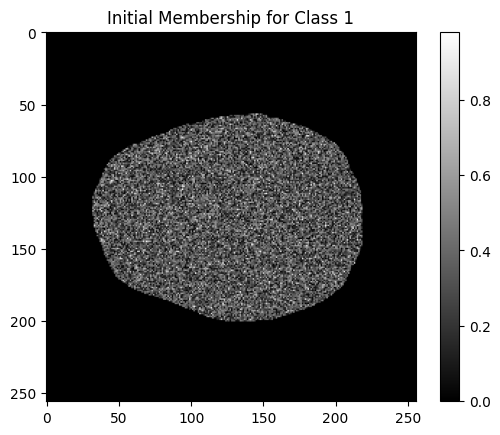

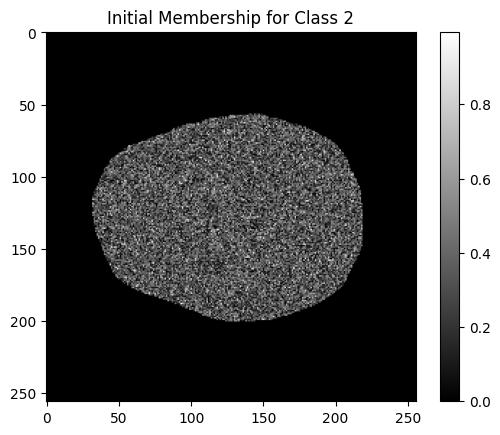

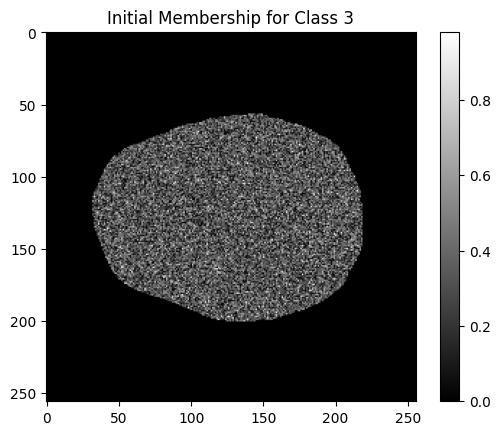

In [9]:
# Work only inside the brain mask
indices = np.where(mask)
n_pixels = len(indices[0])

# Initialize membership values randomly (for each pixel inside the brain)
memberships = np.random.rand(n_pixels, K)
memberships = memberships / np.sum(memberships, axis=1, keepdims=True)

# Display initial membership images for each class
for k in range(K):
    mem_img = np.zeros_like(Y)
    mem_img[indices] = memberships[:, k]
    plt.figure()
    plt.imshow(mem_img, cmap='gray')
    plt.title(f"Initial Membership for Class {k+1}")
    plt.colorbar()
    plt.show()

In [10]:
# Initialize class means by randomly choosing K pixel intensities (inside mask)
class_means = np.random.choice(Y[indices], K, replace=False)
print("Initial class means:", class_means)

Initial class means: [0.66713569 0.63374666 0.49323865]


In [11]:
# Initialize bias field as a constant image (ones everywhere)
bias_field = np.ones_like(Y)

# To track the objective function value at each iteration
obj_history = []

# Main optimization loop
for iteration in range(max_iter):
    memberships_old = memberships.copy()
    
    # ----- STEP 1: Update Class Means -----
    new_means = np.zeros(K)
    for k in range(K):
        # Compute weighted sum using current memberships (raised to q) and bias field
        u_k = memberships[:, k] ** q
        b_n = bias_field[indices]
        Y_n = Y[indices]
        numerator = np.sum(u_k * b_n * Y_n)
        denominator = np.sum(u_k * (b_n**2)) + 1e-10  # avoid division by zero
        new_means[k] = numerator / denominator
    class_means = new_means
    
    # ----- STEP 2: Update Membership Values -----
    # Compute distances from each pixel intensity to each class mean (accounting for bias field)
    distances = np.zeros((n_pixels, K))
    for k in range(K):
        distances[:, k] = (Y[indices] - bias_field[indices] * class_means[k])**2 + 1e-10
    # Update memberships using the FCM update formula
    for k in range(K):
        memberships[:, k] = 1.0 / np.sum((distances[:, k][:, np.newaxis] / distances)**(1/(q-1)), axis=1)
    
    # ----- STEP 3: Update Bias Field -----
    # For each pixel, update bias using weighted class means
    numerator_b = np.sum(memberships**q * class_means, axis=1)
    denominator_b = np.sum(memberships**q * (class_means**2), axis=1) + 1e-10
    b_update = (Y[indices] * numerator_b) / denominator_b
    bias_field[indices] = b_update
    # Enforce smoothness by convolving with the Gaussian neighborhood mask
    bias_field = convolve(bias_field, kernel, mode='reflect')
    
    # ----- Compute Objective Function -----
    obj = 0
    for i in range(n_pixels):
        for k in range(K):
            obj += (memberships[i, k] ** q) * (Y[indices][i] - bias_field[indices][i] * class_means[k])**2
    obj_history.append(obj)
    print(f"Iteration {iteration+1}, Objective: {obj:.6f}")
    
    # Convergence check based on change in memberships
    if np.linalg.norm(memberships - memberships_old) < tol:
        print("Convergence reached at iteration", iteration+1)
        break

# ----- Compute Bias-Removed and Residual Images -----
A_image = np.zeros_like(Y)  # Bias-removed image
R_image = np.zeros_like(Y)  # Residual image
# For pixels inside the brain: A = weighted sum of class means, R = Y - A * bias_field
A_vals = np.sum(memberships * class_means[np.newaxis, :], axis=1)
A_image[indices] = A_vals
R_image[indices] = Y[indices] - A_vals * bias_field[indices]


Iteration 1, Objective: 78.820095
Iteration 2, Objective: 74.105079
Iteration 3, Objective: 72.094475
Iteration 4, Objective: 68.547240
Iteration 5, Objective: 61.988617
Iteration 6, Objective: 55.294081
Iteration 7, Objective: 49.908817
Iteration 8, Objective: 45.354714
Iteration 9, Objective: 40.992971
Iteration 10, Objective: 37.210280
Iteration 11, Objective: 34.766549
Iteration 12, Objective: 33.603448
Iteration 13, Objective: 33.144817
Iteration 14, Objective: 32.987673
Iteration 15, Objective: 32.967665
Iteration 16, Objective: 33.007738
Iteration 17, Objective: 33.058416
Iteration 18, Objective: 33.098541
Iteration 19, Objective: 33.123939
Iteration 20, Objective: 33.136461


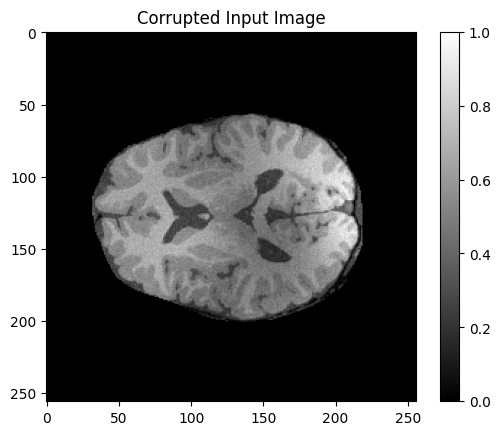

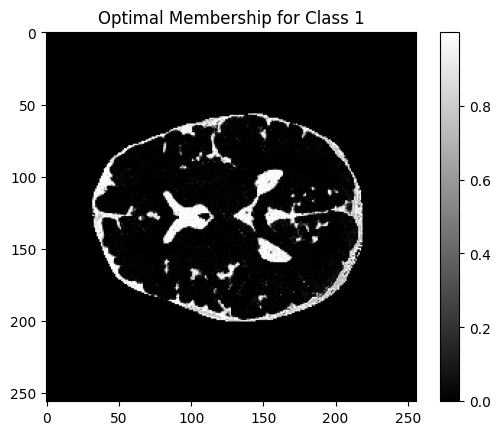

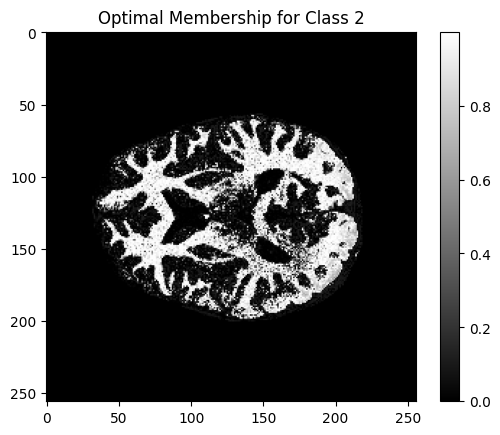

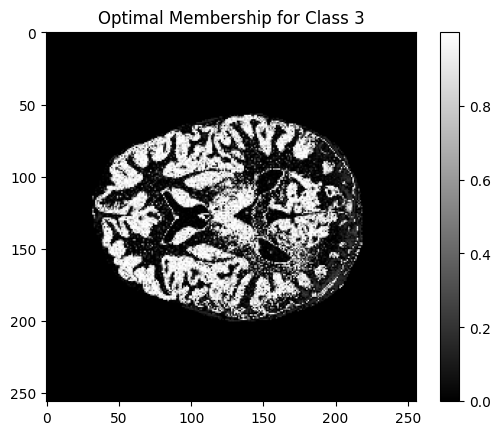

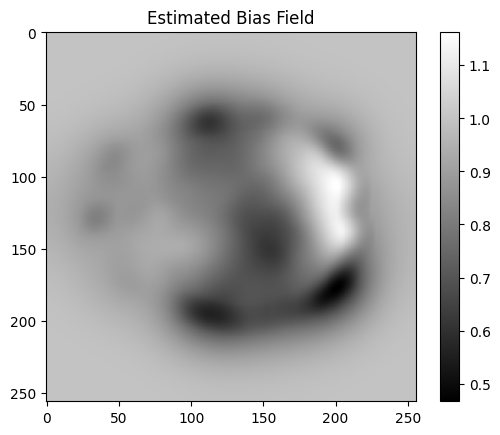

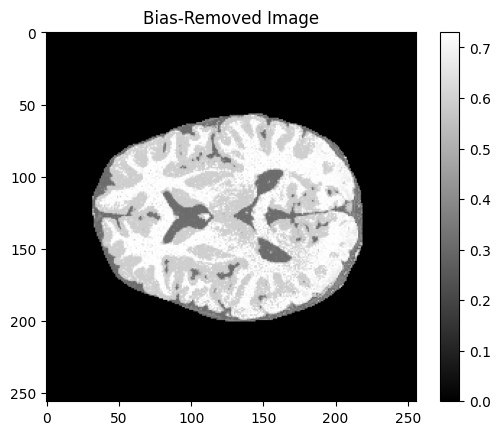

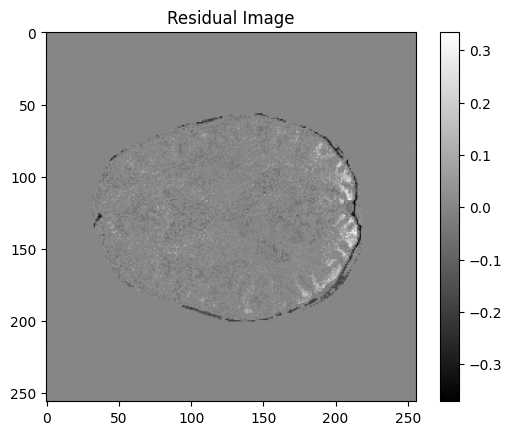

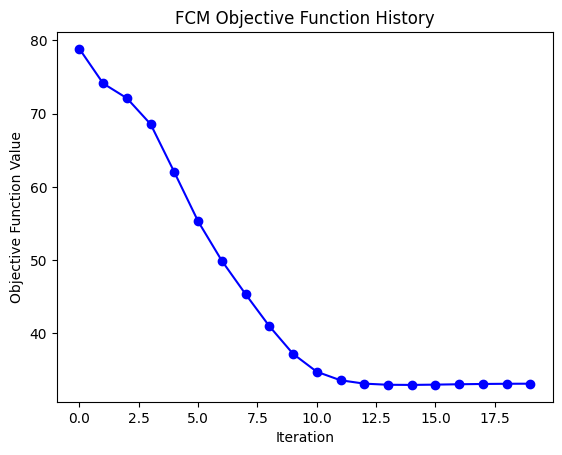

ValueError: cannot reshape array of size 21282 into shape (256,256)

In [12]:

# Display final images
plt.figure()
plt.imshow(Y, cmap='gray')
plt.title("Corrupted Input Image")
plt.colorbar()
plt.show()

# Display the optimal class membership image estimates (one image per class)
for k in range(K):
    mem_img_opt = np.zeros_like(Y)
    mem_img_opt[indices] = memberships[:, k]
    plt.figure()
    plt.imshow(mem_img_opt, cmap='gray')
    plt.title(f"Optimal Membership for Class {k+1}")
    plt.colorbar()
    plt.show()
    
plt.figure()
plt.imshow(bias_field, cmap='gray')
plt.title("Estimated Bias Field")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(A_image, cmap='gray')
plt.title("Bias-Removed Image")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(R_image, cmap='gray')
plt.title("Residual Image")
plt.colorbar()
plt.show()

plt.figure()
plt.plot(obj_history, 'bo-')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('FCM Objective Function History')
plt.show()

# Return results for reporting if needed
results = {
    'memberships': [np.reshape(memberships[:, k], mask.shape) for k in range(K)],
    'class_means': class_means,
    'bias_field': bias_field,
    'A_image': A_image,
    'R_image': R_image,
    'obj_history': obj_history
}
print(results)